# GBM
- Data Split 
    - Apply 80/20 split by Ticker
    - For calculating performance, use 5 fold cross validation (RMSE, Accuracy (1 if positive, 0 if not))
- Build GBM by Ticker

In [171]:
import xgboost
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [172]:
TICKER = "TSLA"
TEST_FRAC = 0.20
RESPONSE_VAR = "close_t+1"

In [173]:
df = pd.read_parquet("../data/processed/daily_with_finbert_and_indicators.parquet")

In [174]:
df.shape

(2490, 805)

In [175]:
df.head()

,ticker,date,open,high,low,close,volume,return_t+1,headlines,finbert_0,...,open_smoothed_alpha:0.9,close_smoothed_alpha:0.25,close_smoothed_alpha:0.75,close_smoothed_alpha:0.9,return_t+1_smoothed_alpha:0.25,return_smoothed_alpha:0.25,return_t+1_smoothed_alpha:0.75,return_smoothed_alpha:0.75,return_t+1_smoothed_alpha:0.9,return_smoothed_alpha:0.9
0,AAPL,2024-05-01,169.580002,172.710007,169.110001,169.300003,50383100.0,0.022032,[],0.000000,...,169.580002,169.300003,169.300003,169.300003,0.022032,NaN,0.022032,NaN,0.022032,NaN
1,AAPL,2024-05-02,172.509995,173.419998,170.889999,173.029999,94214900.0,0.059816,[],0.000000,...,172.216995,170.232502,172.097500,172.656999,0.031478,0.022032,0.050370,0.022032,0.056038,0.022032
2,AAPL,2024-05-03,186.649994,187.000000,182.660004,183.380005,163224100.0,-0.009107,[],0.000000,...,185.206694,173.519378,180.559379,182.307704,0.021332,0.031478,0.005762,0.050370,-0.002592,0.056038
3,AAPL,2024-05-06,182.350006,184.199997,180.419998,181.710007,78569700.0,0.003797,[],0.000000,...,182.635675,175.567035,181.422350,181.769776,0.016948,0.021332,0.004289,0.005762,0.003158,-0.002592
4,AAPL,2024-05-07,183.449997,184.899994,181.320007,182.399994,77305800.0,0.001864,[From Apple to Wayfair: A Lot of Earnings Resu...,0.030524,...,183.368565,177.275275,182.155583,182.336972,0.013177,0.016948,0.002470,0.004289,0.001994,0.003158


In [176]:
df.tail()

,ticker,date,open,high,low,close,volume,return_t+1,headlines,finbert_0,...,open_smoothed_alpha:0.9,close_smoothed_alpha:0.25,close_smoothed_alpha:0.75,close_smoothed_alpha:0.9,return_t+1_smoothed_alpha:0.25,return_smoothed_alpha:0.25,return_t+1_smoothed_alpha:0.75,return_smoothed_alpha:0.75,return_t+1_smoothed_alpha:0.9,return_smoothed_alpha:0.9
2485,XOM,2025-04-23,108.809998,109.300003,106.470001,107.370003,14235700.0,0.011735,[Will Exxon (XOM) Beat Estimates Again in Its ...,0.067738,...,108.536702,106.228441,107.430955,107.434789,0.005872,0.003918,0.008416,-0.001541,0.010030,-0.005316
2486,XOM,2025-04-24,107.970001,108.879997,106.959999,108.629997,9849600.0,-0.000552,[Exxon Mobil (NYSE:XOM) Partners With Calpine ...,0.076386,...,108.026671,106.828830,108.330237,108.510476,0.004266,0.005872,0.001690,0.008416,0.000506,0.010030
2487,XOM,2025-04-25,108.139999,108.760002,107.419998,108.570000,11245800.0,0.000553,[Guyana Q1 oil production sees 3% YoY increase...,-0.027245,...,108.128667,107.264123,108.510059,108.564047,0.003338,0.004266,0.000837,0.001690,0.000548,0.000506
2488,XOM,2025-04-28,108.750000,109.250000,107.680000,108.629997,13890900.0,-0.002485,[Oil Slumps as Traders Await Next Moves in Chi...,-0.336978,...,108.687867,107.605591,108.600013,108.623402,0.001882,0.003338,-0.001655,0.000837,-0.002182,0.000548
2489,XOM,2025-04-29,107.739998,108.830002,107.519997,108.360001,9483100.0,-0.025194,"[Exxon Mobil Q1 Earnings Boosted by Upstream, ...",-0.062517,...,107.834785,107.794194,108.420004,108.386341,-0.004887,0.001882,-0.019309,-0.001655,-0.022893,-0.002182


## Add Close @ T+1 as a variable to test modeling

In [177]:
df["close_t+1"] = df["close"].shift(-1)

In [178]:
df[["close", "close_t+1"]].head()

,close,close_t+1
0,169.300003,173.029999
1,173.029999,183.380005
2,183.380005,181.710007
3,181.710007,182.399994
4,182.399994,182.740005


### Apply data split
- For initial test, build model on 80% and validate on 20% OOT
    - Tune hyperparameters using CV on Train set

- For future, always validate on most recent 2-months and add additional 

In [179]:
df = df.query(f"ticker == '{TICKER}'").reset_index(drop=True)

In [180]:
df = df.sort_values("date")

In [181]:
train = df.loc[df.index <= int(df.shape[0] * (1 - TEST_FRAC)), :]
test = df.loc[df.index > int(df.shape[0] * (1 - TEST_FRAC)), :]

In [182]:
train.shape, test.shape

((200, 806), (49, 806))

### Build initial model on `returns_t+1` 
- Use ARIMA as a baseline (and potentially use as a feature)
- Test using `close_t+1` and `return_t+1_>0`

In [183]:
keys = ["ticker", "date"]
non_modeling_vars = ["headlines", *[col for col in df.columns if "t+1" in col]]
print(non_modeling_vars)

['headlines', 'return_t+1', 'return_t+1_smoothed_alpha:0.25', 'return_t+1_smoothed_alpha:0.75', 'return_t+1_smoothed_alpha:0.9', 'close_t+1']


In [184]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# Prepare the features and target
X = train.drop(columns=keys + non_modeling_vars)
y = train[RESPONSE_VAR]

# Parameters for XGBoost
params = {
    'objective': 'reg:squarederror',  # Regression task
    'eval_metric': 'rmse',  # We use RMSE for evaluation
    'max_depth': 5,
    'learning_rate': 0.1,
    'n_estimators': 250,  # Sufficient large number for early stopping
}

# TimeSeriesSplit for sequential cross-validation
tscv = TimeSeriesSplit(n_splits=3)

# Store the results of each fold for later inspection
results = []
feature_importances_list = []
best_rounds = []

# Perform CV for each split
for train_index, test_index in tscv.split(X):
    # Split the data into training and testing sets based on time series split
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Convert to DMatrix for XGBoost
    dtrain_split = xgb.DMatrix(X_train, label=y_train)
    dtest_split = xgb.DMatrix(X_test, label=y_test)

    # Perform cross-validation with early stopping
    cv_results = xgb.cv(
        params=params,
        dtrain=dtrain_split,
        num_boost_round=250,
        nfold=3,  
        early_stopping_rounds=10, 
        verbose_eval=25,
        seed=99
    )

    # Extract the best number of boosting rounds based on CV performance
    best_round = cv_results['test-rmse-mean'].argmin()
    print(f"Best boosting rounds for this split: {best_round}")
    best_rounds.append(best_round)
    
    # Train the final model with the best number of rounds
    model = xgb.train(
        params=params,
        dtrain=dtrain_split,
        num_boost_round=best_round
    )

    # Predict on the test set
    y_pred = model.predict(dtest_split)
    
    # Evaluate the model (e.g., RMSE)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(f"RMSE for this fold: {rmse}")
    results.append(rmse)

    # Extract feature importances for this iteration
    feature_importances = model.get_score(importance_type='weight')

    # Sort the feature importances in descending order
    sorted_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
    
    # Store the sorted feature importances in a list for this fold
    feature_importances_list.append(dict(sorted_importances))
    
# Average RMSE across all folds
average_rmse = np.mean(results)
print(f"Average RMSE across all folds: {average_rmse}")


[13:32:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[13:32:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[13:32:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	train-rmse:175.89925+3.30754	test-rmse:175.92742+7.62730
[25]	train-rmse:16.69372+0.04475	test-rmse:18.70992+4.08962
[50]	train-rmse:2.37875+0.14699	test-rmse:8.97048+1.83040
[60]	train-rmse:1.25652+0.15812	test-rmse:9.13522+1.70307
Best boosting rounds for this split: 51
[13:32:20] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

RMSE for this fold: 14.343130791381643
[13:32:20] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 


In [185]:
# Select final features by taking top 100 features from each model where there is overlap
first_intersection = np.intersect1d(
    list(feature_importances_list[0].keys())[:100],
    list(feature_importances_list[1].keys())[:100]
    )
second_intersection = np.intersect1d(
    first_intersection,
    list(feature_importances_list[2].keys())[:100]
    )

In [186]:
second_intersection

array(['close', 'finbert_0', 'finbert_1', 'finbert_19', 'finbert_2',
       'finbert_253', 'finbert_281', 'finbert_386', 'finbert_390',
       'finbert_654', 'finbert_69', 'high', 'low', 'open',
       'return_smoothed_alpha:0.25', 'sma_20', 'sma_5', 'volatility_5',
       'volume'], dtype='<U26')

## Build model on full training set with only overlapping features
- Evaluate on test set

In [187]:
num_rounds = int(sum(best_rounds) / len(best_rounds))
num_rounds

80

In [189]:
# Prepare the features and target
X = df[second_intersection]
y = df[RESPONSE_VAR]

X_train = train[second_intersection]
y_train = train[RESPONSE_VAR]

# Parameters for XGBoost
params = {
    'objective': 'reg:squarederror',  # Regression task
    'eval_metric': 'rmse',  # We use RMSE for evaluation
    'max_depth': 5,
    'learning_rate': 0.1,
    'n_estimators': 250,  # Sufficient large number for early stopping
}

# Convert to DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dfull = xgb.DMatrix(X, label=y)

# Train the final model with the best number of rounds
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=num_rounds
)

[13:33:05] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



In [190]:
# Predict on the test set
y_pred = model.predict(dfull)

# Extract feature importances for this iteration
feature_importances = model.get_score(importance_type='gain')

# Sort the feature importances in descending order
sorted_importance = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

In [191]:
sorted_importance

[('close', 31705.02734375),
 ('sma_20', 13364.068359375),
 ('low', 5450.501953125),
 ('high', 3569.225830078125),
 ('open', 293.1822509765625),
 ('volatility_5', 104.69357299804688),
 ('finbert_654', 100.44763946533203),
 ('finbert_1', 76.71449279785156),
 ('return_smoothed_alpha:0.25', 65.85652923583984),
 ('sma_5', 63.81459426879883),
 ('finbert_390', 56.72386169433594),
 ('finbert_253', 55.15563201904297),
 ('finbert_386', 54.47393798828125),
 ('finbert_69', 54.35468673706055),
 ('finbert_19', 40.98419189453125),
 ('finbert_2', 39.81673812866211),
 ('finbert_281', 35.9548225402832),
 ('volume', 33.6352653503418),
 ('finbert_0', 31.780298233032227)]

### Plot predictions on train going into test set
- What % of the time is the prediction directionally correct?
- How accurate is the prediction?

In [192]:
TEST_START_INDEX = 200

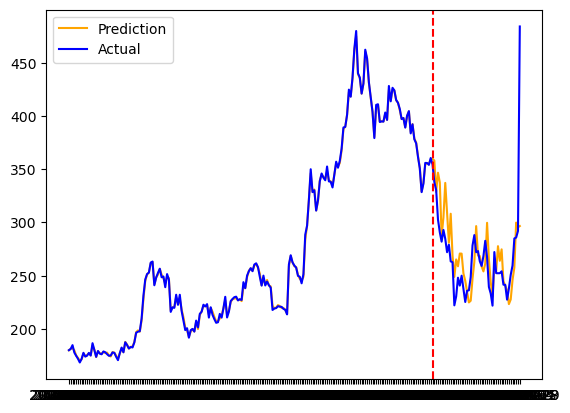

In [193]:
plt.plot(df["date"], y_pred, color="orange")
plt.plot(df["date"], df[RESPONSE_VAR], color = "blue")
plt.legend(labels=["Prediction", "Actual"])
plt.axvline(TEST_START_INDEX, color="red", linestyle="--")

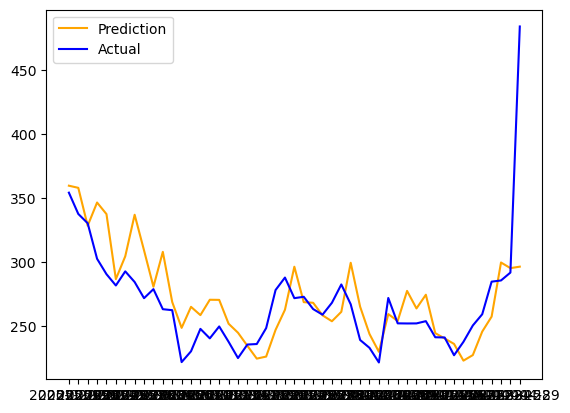

In [194]:
plt.plot(df.loc[TEST_START_INDEX:, "date"], y_pred[TEST_START_INDEX:], color="orange")
plt.plot(df.loc[TEST_START_INDEX:, "date"], df.loc[TEST_START_INDEX:, RESPONSE_VAR], color = "blue")
plt.legend(labels=["Prediction", "Actual"])